In [1]:
#Importación de Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Cargar y preparar los datos

El dataset **Iris** es un conjunto de datos de clasificación multiclase clásico y muy sencillo. Introducido por el estadístico y biólogo británico Ronald Fisher en su artículo de 1936 "The use of multiple measurements in taxonomic problems".

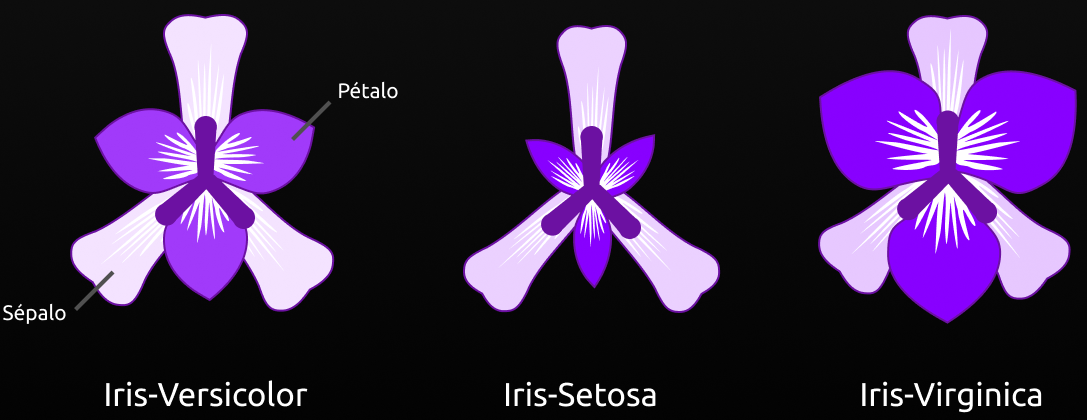

El conjunto de datos de Iris contiene cuatro características (longitud y anchura de sépalos y pétalos) de 50 muestras de tres especies de flores Iris (Iris setosa, Iris virginica e Iris versicolor).

**El objetivo es construir un modelo que utilice las características para clasificar las flores con un máximo de precisión.**

Este conjunto de datos consta de tres tipos diferentes de iris:

0. -> Setosa,
1. -> Versicolour
2. -> Virginica

Las filas son las muestras y las columnas son:
* longitud del sépalo,
* anchura del sépalo,
* longitud del pétalo,
* anchura del pétalo.

<br>

En la celda a continuacion, cargamos el conjunto de datos, aseguramos la forma correcta de los datos y realizamos la division entre datos de entrenamiento y prueba (train / test).

In [2]:
iris = load_iris()
X = iris.data  # características (150 x 4)
y = iris.target.reshape(-1, 1)  # etiquetas (150 x 1)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)#, random_state=42

Se ha definido la funcion **`Metrics`** que calculara las diversas metricas de evaluacion que se puede aplicar a un modelo de clasificacion.

In [3]:
from sklearn import metrics

def Metrics(y_real, y_pred):
    acc = metrics.accuracy_score(y_real, y_pred)
    prec = metrics.precision_score(y_real, y_pred, average='macro')
    rec = metrics.recall_score(y_real, y_pred, average='macro')
    f = metrics.f1_score(y_real, y_pred, average='macro')

    print("El score promedio de todas las clases:")
    # Calcula las métricas para cada etiqueta y encuentra su media no ponderada. No tiene en cuenta el desequilibrio de las etiquetas.
    print("\nAccuracy:  {:.2f}%".format(acc * 100))  # (TP+TN)/Total / number of classes
    print("Precision: {:.2f}%".format(prec * 100))  # TP/(TP+FP) / number of classes
    print("Recall:    {:.2f}%".format(rec * 100))  # TP/(TP+FN) / number of classes
    print("F-measure: {:.2f}%".format(f * 100))  # 2 * (prec*rec)/(prec+rec) / number of classes

    print("\nMatriz de confusion:")
    print(metrics.confusion_matrix(y_real, y_pred))

A continuacion, completa las funciones de calculo de la funcion **`softmax`** y entropia cruzada (**`cross_entropy`**):

In [4]:
def softmax(z):
  """
  Calcula la función softmax para cada fila de z.
  Args:
      z (np.ndarray): Matriz de logits de tamaño (n_samples, n_classes).
  Returns:
      np.ndarray: Probabilidades normalizadas con softmax (n_samples, n_classes).
  """
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
  """
  Calcula la pérdida cross-entropy entre etiquetas verdaderas y predicciones.
  Args:
      y_true (np.ndarray): Etiquetas reales en one-hot encoding (n_samples, n_classes).
      y_pred (np.ndarray): Probabilidades predichas con softmax (n_samples, n_classes).
  Returns:
      float: Valor escalar de la pérdida promedio de entropía cruzada.
  """
  n_samples = y_true.shape[0]
  epsilon = 1e-15
  y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
  loss = -np.sum(y_true * np.log(y_pred)) / n_samples
  return loss

Investiga y responde las siguientes interrogantes:

* **¿Por qué la función softmax es adecuada para clasificación multiclase y su relacion con los logits?**
* **¿Qué ocurre si los logits son muy grandes o muy pequeños?¿Que se puede hacer para estos escenarios**
* **¿Cómo se relaciona la entropía cruzada con la verosimilitud máxima?**

```
1.- Softmax convierte los logits (salidas no normalizadas) en probabilidades para cada clase, siendo ideal para clasificación multiclase.
2.- Logits extremos pueden causar inestabilidad numérica (desbordamiento/subdesbordamiento) en Softmax. Se estabiliza restando el máximo logit antes de la exponencial.
3.- Minimizar la entropía cruzada es equivalente a maximizar la verosimilitud de los datos bajo el modelo, buscando los parámetros que hacen las etiquetas verdaderas más probables.
```

En seguida, completa la clase de nuestro modelo de regresion logistica multiclase, donde:
* Realizaras predicciones de probabilidades,
* Entrenamiento del modelo utilizando gradiente descendiente, y
* Prediccion de las clases.

In [5]:
# ------------------------
# Regresión logística multiclase
# ------------------------
class MulticlassLogisticRegression:
  def __init__(self):
    self.W = None
    self.b = None
    self.loss = []

  def predict_proba(self, X):
    """
    Realiza una predicción utilizando los parámetros actuales: self.W, self.b.
    Args:
        X (np.ndarray): Matriz de características (n_samples, n_features).
    Returns:
        np.ndarray: Probabilidades para cada clase (n_samples, n_classes).
    """
    z = X @ self.W + self.b
    return softmax(z)

  def fit(self, X, Y, lr, epochs):
    """
    Entrena un modelo de regresión logística multiclase con softmax.
    Actualiza Pesos entrenados self.W (n_features, n_classes), Sesgos entrenados self.b (1, n_classes) e historial de loss self.loss.
    Args:
        X (np.ndarray): Matriz de características (n_samples, n_features).
        Y (np.ndarray): Etiquetas para cada una de las muestras (n_samples, ).
        lr (float): Tasa de aprendizaje.
        epochs (int): Número de iteraciones de entrenamiento.
    Returns:
        None
    """
    # One-hot encoding de las etiquetas
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(Y)  # (150 x 3)

    # Adquirir dimensiones
    n_samples, n_features = X.shape
    n_classes = y.shape[1]

    # Inicialización
    self.W = np.random.random((n_features, n_classes))
    self.b = np.random.random((1, n_classes))

    # Gradiente descendente:
    for epoch in range(epochs):
      # Forward pass
      z = X @ self.W + self.b
      y_pred = softmax(z)

      # Calcular la pérdida
      loss = cross_entropy(y, y_pred)
      self.loss.append(loss)

      # Backward pass (gradientes)
      dz = y_pred - y
      dW = (X.T @ dz) / n_samples
      db = np.sum(dz, axis=0, keepdims=True) / n_samples

      # Actualizar pesos y sesgos
      self.W -= lr * dW
      self.b -= lr * db

  def predict(self, X):
    """
    Regresa la prediccion de clase segun la probabilidad mas alta.
    Args:
        X (np.ndarray): Matriz de características (n_samples, n_features).
    Returns:
        np.ndarray: clases predichas para cada muestra (n_samples, ).
    """
    return np.argmax(self.predict_proba(X), axis=1)

  def print_loss(self):
    """
    Grafica el historial de la funcion de perdida a lo largo del entrenamiento
    """
    plt.figure(figsize=(14, 7))
    x_axis = np.arange(1,len(self.loss)+1)
    plt.plot(x_axis, self.loss)
    plt.grid()
    plt.show()

## Entrenar modelo
* Experimenta y elige los mejores parametros (**`lr`**, **`epochs`**)
* Entrena el modelo (**`fit()`**)
* Realiza una prediccion con los datos de test (**`X_test`**)

In [6]:
# Entrenar modelo
model = MulticlassLogisticRegression()

lr=0.1
epochs=1000

model.fit(X_train, y_train, lr, epochs)
y_pred = model.predict(X_test)

print("Pesos:\n", model.W)
print("Bias:\n", model.b)

Pesos:
 [[ 1.32271136  1.28798961 -1.28026497]
 [ 2.40704718  0.08994534 -1.13418387]
 [-1.96168688  0.62308055  3.76879148]
 [-1.09691837 -0.81330775  2.74003459]]
Bias:
 [[ 0.88062102  0.69951332 -0.87111262]]


Responde las siguientes interrogantes:

* **¿Qué pasa si elegimos una tasa de aprendizaje ($α$) muy grande o muy pequeña?**
* **¿Qué significa el número de épocas?¿Que es la idea de *early stopping*?**

```
1.- Una tasa de aprendizaje grande puede causar saltos, y una pequeña un entrenamiento lento.
2.- Época es una pasada completa por los datos de entrenamiento. Early stopping detiene el entrenamiento temprano para evitar sobreajuste, basado en el rendimiento en datos de validación.
```


## Calcula las metricas de evaluacion del modelo

In [8]:
Metrics(y_test, y_pred)

El score promedio de todas las clases:

Accuracy:  96.67%
Precision: 95.24%
Recall:    97.44%
F-measure: 96.10%

Matriz de confusion:
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]


Responde las siguientes interrogantes:

* **¿Qué clases son más fáciles o difíciles de separar?**



```
La clase Setosa (0) es la más fácil de separar, sin errores de clasificación.
Las clases Versicolor (1) y Virginica (2) son un poco más difíciles de separar entre sí, con un pequeño número de clasificaciones erróneas entre ellas.
```



## Grafica la curva de entrenamiento del modelo

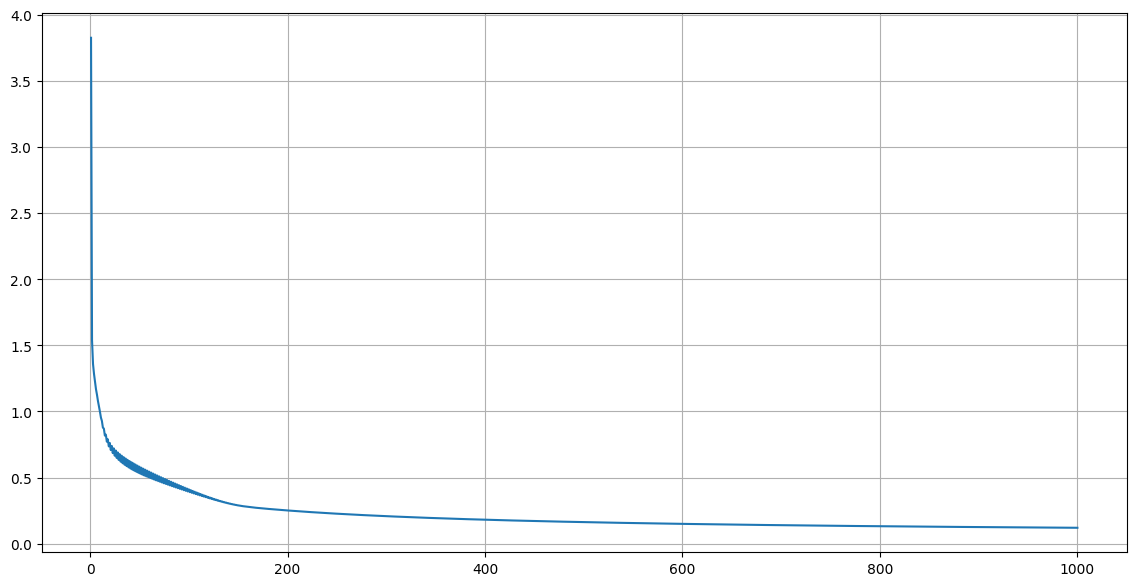

In [9]:
model.print_loss()

Responde las siguientes interrogantes:

* **¿Qué se puede decir de la calidad de entrenamiento viendo la grafica de entrenamiento y los resultado obtenidos con el conjunto de test?**

```
La curva de pérdida decreciente y las altas métricas en el conjunto de prueba indican que el modelo ha aprendido bien y generaliza correctamente, sin signos claros de sobreajuste.
```

---
# Modelo #2

Entrena un nuevo modelo de regresión logística multiclase (nombralo de manera diferente al primero) usando solo las dos características del Iris dataset: **`petal length`** y **`petal width`**.

* Guarda el conjunto de datos en una variable nombrada de manera diferente.
* particiona los datos en **`train`**/**`test`**.

In [10]:
iris_petal = load_iris()
X_petal = iris_petal.data[:, 2:]
y_petal = iris_petal.target.reshape(-1, 1)

X_train_petal, X_test_petal, y_train_petal, y_test_petal = train_test_split(X_petal, y_petal, test_size=0.2, random_state=1)

* Entrena con **`train`** y calcula las metricas de evaluacion con **`test`**.

In [11]:
model_petal = MulticlassLogisticRegression()

lr_petal = 0.1
epochs_petal = 1000

model_petal.fit(X_train_petal, y_train_petal, lr_petal, epochs_petal)
y_pred_petal = model_petal.predict(X_test_petal)

print("Métricas del modelo entrenado con características de pétalo:")
Metrics(y_test_petal, y_pred_petal)

Métricas del modelo entrenado con características de pétalo:
El score promedio de todas las clases:

Accuracy:  93.33%
Precision: 91.67%
Recall:    94.87%
F-measure: 92.46%

Matriz de confusion:
[[11  0  0]
 [ 0 11  2]
 [ 0  0  6]]


Responde las siguientes interrogantes:

* **¿Qué pasa si usamos solo dos características (largo y ancho del pétalo)?¿Mejora o empeora el rendimiento?¿A que se lo adjudicas?**


```
El rendimiento del modelo empeora ligeramente al usar solo las características del pétalo en comparación con usar las cuatro características. Esto se debe a que se usa menos información, aunque las características del pétalo son importantes, el uso de las características del sépalo también ayuda a mejorar la separación entre clases.
```

* Utiliza la funcion **`decision_boundary_plot`** con el conjunto de datos **`test`** y el **`modelo`** entrenado con la variante de los datos.

In [13]:
def decision_boundary_plot(Modelo, X, Y, target_names=iris.target_names):
  x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
  y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

  Z = Modelo.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
  # Puntos de datos
  for i, label in enumerate(target_names):
    plt.scatter(X[Y.flatten() == i, 0],
                X[Y.flatten() == i, 1],
                label=label, edgecolor="k")

  plt.xlabel("Largo del pétalo (cm)")
  plt.ylabel("Ancho del pétalo (cm)")
  plt.title("Frontera de decisión - Regresión Logística Multiclase (Softmax)")
  plt.legend()
  plt.show()

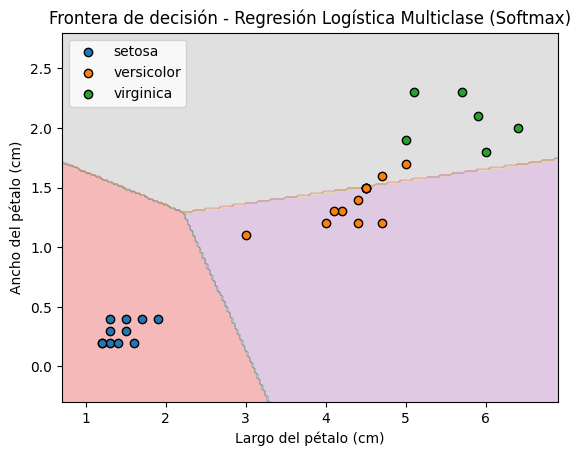

In [14]:
decision_boundary_plot(model_petal, X_test_petal, y_test_petal)

Responde las siguientes interrogantes:

* **¿Qué clases son más fáciles o difíciles de separar en este caso?**

*   La clase Setosa (azul) es la más fácil de separar, claramente aislada por una frontera lineal.
*   Las clases Versicolor (naranja) y Virginica (verde) son más difíciles de separar entre sí, con puntos mezclados cerca de la frontera de decisión.